# Autism Spectrum Disorder Detection - Data Preparation and Model Training

This notebook prepares data from the AutismDataset folder and trains multiple deep learning models for autism spectrum disorder detection.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Preparation

We'll create DataFrames for train, validation, and test sets from the AutismDataset folder structure.

In [2]:
# Base paths
base_path = '/kaggle/input/autism-image-data/AutismDataset'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

def create_dataframe_from_flat_directory(directory_path, split_name):
    """
    Create DataFrame from flat directory structure (train/test)
    Files are named like: Autistic.X.jpg, Non_Autistic.X.jpg
    """
    data = []
    
    # Get all jpg files
    all_files = glob.glob(os.path.join(directory_path, '*.jpg'))
    
    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        # Determine label from filename
        if filename.startswith('Autistic.'):
            label = 'Autistic'
        elif filename.startswith('Non_Autistic.'):
            label = 'Non_Autistic'
        else:
            continue  # Skip files that don't match our pattern
        
        data.append({
            'image_path': file_path,
            'labels': label,
            'split': split_name
        })
    
    return pd.DataFrame(data)

def create_dataframe_from_subdirectory(directory_path, split_name):
    """
    Create DataFrame from subdirectory structure (valid)
    Structure: valid/Autistic/, valid/Non_Autistic/
    """
    data = []
    
    # Process Autistic subdirectory
    autistic_path = os.path.join(directory_path, 'Autistic')
    if os.path.exists(autistic_path):
        autistic_files = glob.glob(os.path.join(autistic_path, '*.jpg'))
        for file_path in autistic_files:
            data.append({
                'image_path': file_path,
                'labels': 'Autistic',
                'split': split_name
            })
    
    # Process Non_Autistic subdirectory
    non_autistic_path = os.path.join(directory_path, 'Non_Autistic')
    if os.path.exists(non_autistic_path):
        non_autistic_files = glob.glob(os.path.join(non_autistic_path, '*.jpg'))
        for file_path in non_autistic_files:
            data.append({
                'image_path': file_path,
                'labels': 'Non_Autistic',
                'split': split_name
            })
    
    return pd.DataFrame(data)

# Create DataFrames for each split
print("Creating train DataFrame...")
train_df = create_dataframe_from_flat_directory(train_path, 'train')

print("Creating validation DataFrame...")
valid_df = create_dataframe_from_subdirectory(valid_path, 'valid')

print("Creating test DataFrame...")
test_df = create_dataframe_from_flat_directory(test_path, 'test')

# Display dataset statistics
print(f"\nDataset Statistics:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(valid_df) + len(test_df)}")

print(f"\nLabel distribution in training set:")
print(train_df['labels'].value_counts())

print(f"\nLabel distribution in validation set:")
print(valid_df['labels'].value_counts())

print(f"\nLabel distribution in test set:")
print(test_df['labels'].value_counts())

Creating train DataFrame...
Creating validation DataFrame...
Creating test DataFrame...

Dataset Statistics:
Training samples: 2540
Validation samples: 100
Test samples: 300
Total samples: 2940

Label distribution in training set:
labels
Non_Autistic    1270
Autistic        1270
Name: count, dtype: int64

Label distribution in validation set:
labels
Autistic        50
Non_Autistic    50
Name: count, dtype: int64

Label distribution in test set:
labels
Non_Autistic    150
Autistic        150
Name: count, dtype: int64


## Display Sample Data

In [3]:
# Display first few rows of each DataFrame
print("Training DataFrame Sample:")
print(train_df.head())

print("\nValidation DataFrame Sample:")
print(valid_df.head())

print("\nTest DataFrame Sample:")
print(test_df.head())

Training DataFrame Sample:
                                          image_path        labels  split
0  /kaggle/input/autism-image-data/AutismDataset/...  Non_Autistic  train
1  /kaggle/input/autism-image-data/AutismDataset/...      Autistic  train
2  /kaggle/input/autism-image-data/AutismDataset/...  Non_Autistic  train
3  /kaggle/input/autism-image-data/AutismDataset/...      Autistic  train
4  /kaggle/input/autism-image-data/AutismDataset/...  Non_Autistic  train

Validation DataFrame Sample:
                                          image_path    labels  split
0  /kaggle/input/autism-image-data/AutismDataset/...  Autistic  valid
1  /kaggle/input/autism-image-data/AutismDataset/...  Autistic  valid
2  /kaggle/input/autism-image-data/AutismDataset/...  Autistic  valid
3  /kaggle/input/autism-image-data/AutismDataset/...  Autistic  valid
4  /kaggle/input/autism-image-data/AutismDataset/...  Autistic  valid

Test DataFrame Sample:
                                          image_path   

## Data Transformations

Define image transformations for training and validation/testing.

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

## Dataset & DataLoader Classes

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class AutismDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with image_path and labels columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = AutismDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = AutismDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = AutismDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [7]:
# Create datasets and dataloaders
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {label_encoder.classes_}")

Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']


## Model Training Framework

In [8]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model
                if phase == 'val' and epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=['Autistic', 'Non_Autistic']))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

## Model Definitions

In [9]:
def create_resnet_model(num_classes=2, pretrained=True):
    """Create ResNet-18 model for binary classification"""
    model = models.resnet18(pretrained=pretrained)
    
    # Modify final layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

def create_vgg_model(architecture='vgg16', num_classes=2, pretrained=True):
    """Create VGG model (16 or 19) for binary classification"""
    if architecture == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
    elif architecture == 'vgg19':
        model = models.vgg19(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be 'vgg16' or 'vgg19'")
    
    # Modify classifier
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model

def create_efficientnet_model(architecture='b0', num_classes=2, pretrained=True):
    """Create EfficientNet model for binary classification"""
    if architecture == 'b0':
        model = models.efficientnet_b0(pretrained=pretrained)
    elif architecture == 'b1':
        model = models.efficientnet_b1(pretrained=pretrained)
    elif architecture == 'b2':
        model = models.efficientnet_b2(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be 'b0', 'b1', or 'b2'")
    
    # Modify classifier
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    return model

## Configure GPU

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. ResNet-18 Training

In [11]:
# Create and train ResNet-18
print("Creating ResNet-18 model...")
resnet_model = create_resnet_model()
resnet_trainer = ModelTrainer(resnet_model, train_loader, val_loader, test_loader, device)

Creating ResNet-18 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [12]:
# Train ResNet-18
print("Training ResNet-18...")
trained_resnet = resnet_trainer.train_model(num_epochs=25, model_name="resnet18")

Training ResNet-18...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  7.97it/s, Loss=0.5451, Acc=0.7571]


Train Loss: 0.5451 Acc: 0.7571


Val : 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, Loss=0.5683, Acc=0.6800]


Val Loss: 0.5683 Acc: 0.6800
✓ New best model saved with validation accuracy: 0.6800

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 14.15it/s, Loss=0.3817, Acc=0.8299]


Train Loss: 0.3817 Acc: 0.8299


Val : 100%|██████████| 4/4 [00:00<00:00,  9.57it/s, Loss=0.4975, Acc=0.7400]


Val Loss: 0.4975 Acc: 0.7400
✓ New best model saved with validation accuracy: 0.7400

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.68it/s, Loss=0.3219, Acc=0.8675]


Train Loss: 0.3219 Acc: 0.8675


Val : 100%|██████████| 4/4 [00:00<00:00,  9.34it/s, Loss=0.7279, Acc=0.7400]


Val Loss: 0.7279 Acc: 0.7400

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.88it/s, Loss=0.2736, Acc=0.8825]


Train Loss: 0.2736 Acc: 0.8825


Val : 100%|██████████| 4/4 [00:00<00:00,  9.33it/s, Loss=0.4785, Acc=0.7700]


Val Loss: 0.4785 Acc: 0.7700
✓ New best model saved with validation accuracy: 0.7700

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.61it/s, Loss=0.2254, Acc=0.9055]


Train Loss: 0.2254 Acc: 0.9055


Val : 100%|██████████| 4/4 [00:00<00:00,  9.40it/s, Loss=0.4998, Acc=0.7900]


Val Loss: 0.4998 Acc: 0.7900
✓ New best model saved with validation accuracy: 0.7900

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.49it/s, Loss=0.1887, Acc=0.9288]


Train Loss: 0.1887 Acc: 0.9288


Val : 100%|██████████| 4/4 [00:00<00:00,  9.21it/s, Loss=0.7340, Acc=0.7800]


Val Loss: 0.7340 Acc: 0.7800

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.96it/s, Loss=0.1609, Acc=0.9379]


Train Loss: 0.1609 Acc: 0.9379


Val : 100%|██████████| 4/4 [00:00<00:00,  9.79it/s, Loss=0.6735, Acc=0.7300]


Val Loss: 0.6735 Acc: 0.7300

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.84it/s, Loss=0.1129, Acc=0.9553]


Train Loss: 0.1129 Acc: 0.9553


Val : 100%|██████████| 4/4 [00:00<00:00,  9.21it/s, Loss=0.8423, Acc=0.7300]


Val Loss: 0.8423 Acc: 0.7300

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.69it/s, Loss=0.1194, Acc=0.9561]


Train Loss: 0.1194 Acc: 0.9561


Val : 100%|██████████| 4/4 [00:00<00:00,  9.32it/s, Loss=0.6608, Acc=0.7500]


Val Loss: 0.6608 Acc: 0.7500

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.89it/s, Loss=0.1065, Acc=0.9585]


Train Loss: 0.1065 Acc: 0.9585


Val : 100%|██████████| 4/4 [00:00<00:00,  9.45it/s, Loss=1.3600, Acc=0.7300]

Val Loss: 1.3600 Acc: 0.7300
Early stopping triggered after 10 epochs
Training complete in 1m 7s
Best validation accuracy: 0.7900


Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Test Accuracy: 81.00%
Test Loss: 0.4098

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.75      0.93      0.83       150
Non_Autistic       0.90      0.69      0.78       150

    accuracy                           0.81       300
   macro avg       0.83      0.81      0.81       300
weighted avg       0.83      0.81      0.81       300


Confusion Matrix:
[[139  11]
 [ 46 104]]


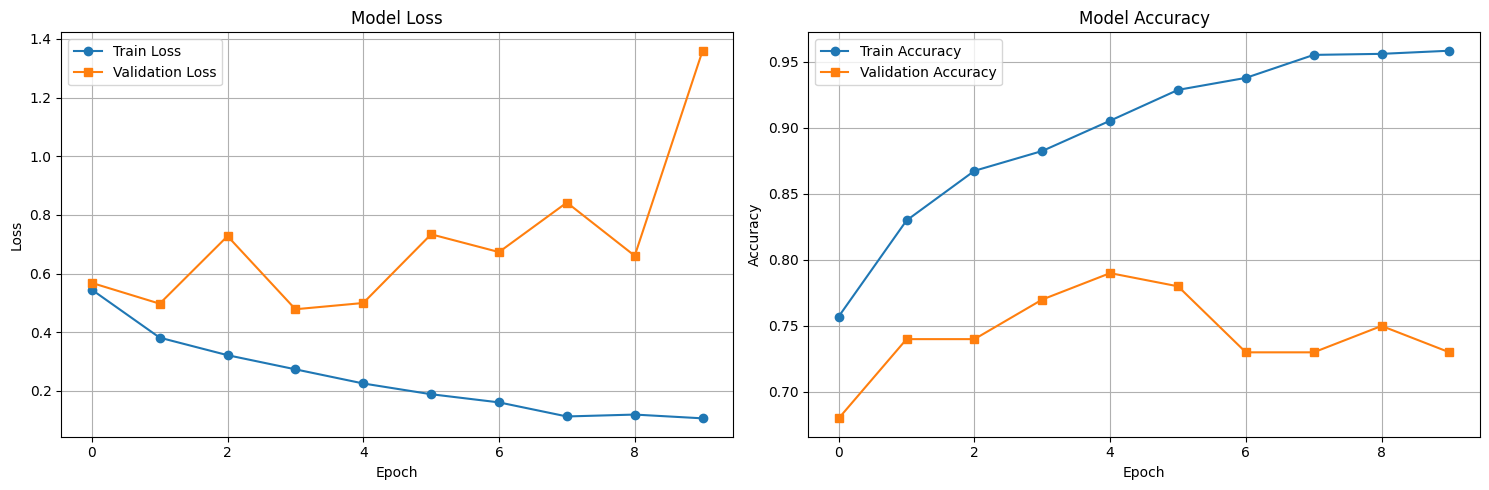

In [13]:
# Evaluate ResNet-18
resnet_test_acc, resnet_preds, resnet_labels = resnet_trainer.evaluate_model()
resnet_trainer.plot_training_history()

## 2. VGG-16 Training

In [14]:
# Create and train VGG-16
print("Creating VGG-16 model...")
vgg16_model = create_vgg_model('vgg16')
vgg16_trainer = ModelTrainer(vgg16_model, train_loader, val_loader, test_loader, device)

Creating VGG-16 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 216MB/s]


In [15]:
# Train VGG-16
print("Training VGG-16...")
trained_vgg16 = vgg16_trainer.train_model(num_epochs=25, model_name='vgg16')

Training VGG-16...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.87it/s, Loss=0.8823, Acc=0.5233]


Train Loss: 0.8823 Acc: 0.5233


Val : 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, Loss=0.6902, Acc=0.5900]


Val Loss: 0.6902 Acc: 0.5900
✓ New best model saved with validation accuracy: 0.5900

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.87it/s, Loss=0.7408, Acc=0.5277]


Train Loss: 0.7408 Acc: 0.5277


Val : 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, Loss=0.6955, Acc=0.5000]


Val Loss: 0.6955 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.88it/s, Loss=0.6970, Acc=0.4953]


Train Loss: 0.6970 Acc: 0.4953


Val : 100%|██████████| 4/4 [00:00<00:00,  7.05it/s, Loss=0.6968, Acc=0.5000]


Val Loss: 0.6968 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.87it/s, Loss=0.7013, Acc=0.4945]


Train Loss: 0.7013 Acc: 0.4945


Val : 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, Loss=0.6972, Acc=0.5000]


Val Loss: 0.6972 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.88it/s, Loss=0.6979, Acc=0.4968]


Train Loss: 0.6979 Acc: 0.4968


Val : 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, Loss=0.6947, Acc=0.5000]


Val Loss: 0.6947 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:20<00:00,  3.87it/s, Loss=0.7300, Acc=0.4830]


Train Loss: 0.7300 Acc: 0.4830


Val : 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, Loss=0.6931, Acc=0.5000]

Val Loss: 0.6931 Acc: 0.5000
Early stopping triggered after 6 epochs
Training complete in 2m 7s
Best validation accuracy: 0.5900


Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


Test Accuracy: 53.00%
Test Loss: 0.6910

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.52      0.85      0.64       150
Non_Autistic       0.58      0.21      0.31       150

    accuracy                           0.53       300
   macro avg       0.55      0.53      0.48       300
weighted avg       0.55      0.53      0.48       300


Confusion Matrix:
[[127  23]
 [118  32]]


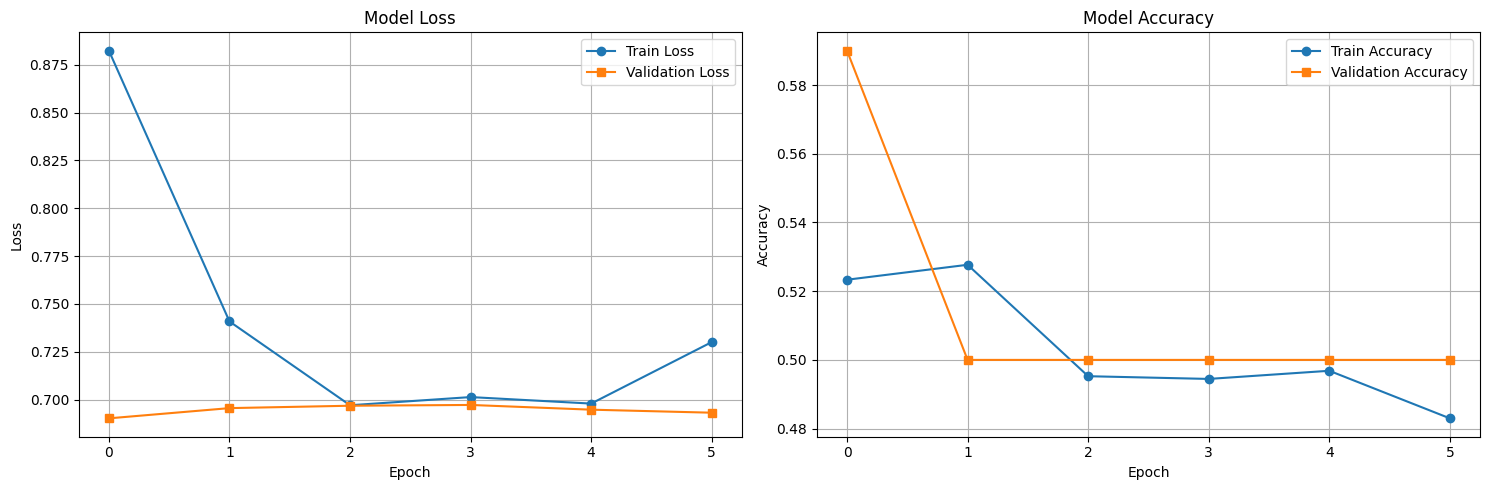

In [16]:
# Evaluate VGG-16
vgg16_test_acc, vgg16_preds, vgg16_labels = vgg16_trainer.evaluate_model()
vgg16_trainer.plot_training_history()

## 3. VGG-19 Training

In [17]:
# Create and train VGG-19
print("Creating VGG-19 model...")
vgg19_model = create_vgg_model('vgg19')
vgg19_trainer = ModelTrainer(vgg19_model, train_loader, val_loader, test_loader, device)

Creating VGG-19 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 232MB/s]


In [18]:
# Train VGG-19
print("Training VGG-19...")
trained_vgg19 = vgg19_trainer.train_model(num_epochs=25, model_name='vgg19')

Training VGG-19...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.36it/s, Loss=0.9446, Acc=0.4822]


Train Loss: 0.9446 Acc: 0.4822


Val : 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, Loss=0.6966, Acc=0.5000]


Val Loss: 0.6966 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.35it/s, Loss=0.7002, Acc=0.5261]


Train Loss: 0.7002 Acc: 0.5261


Val : 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, Loss=0.6676, Acc=0.5700]


Val Loss: 0.6676 Acc: 0.5700
✓ New best model saved with validation accuracy: 0.5700

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.36it/s, Loss=0.7005, Acc=0.5237]


Train Loss: 0.7005 Acc: 0.5237


Val : 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Loss=0.6966, Acc=0.5000]


Val Loss: 0.6966 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.36it/s, Loss=0.8185, Acc=0.4984]


Train Loss: 0.8185 Acc: 0.4984


Val : 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Loss=0.6938, Acc=0.5000]


Val Loss: 0.6938 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.36it/s, Loss=0.9635, Acc=0.4933]


Train Loss: 0.9635 Acc: 0.4933


Val : 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Loss=0.6933, Acc=0.5000]


Val Loss: 0.6933 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.37it/s, Loss=0.6995, Acc=0.4893]


Train Loss: 0.6995 Acc: 0.4893


Val : 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, Loss=0.7041, Acc=0.5000]


Val Loss: 0.7041 Acc: 0.5000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.37it/s, Loss=0.6962, Acc=0.4964]


Train Loss: 0.6962 Acc: 0.4964


Val : 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Loss=0.6932, Acc=0.5000]

Val Loss: 0.6932 Acc: 0.5000
Early stopping triggered after 7 epochs
Training complete in 2m 52s
Best validation accuracy: 0.5700


Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Test Accuracy: 57.33%
Test Loss: 0.6768

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.54      0.93      0.69       150
Non_Autistic       0.76      0.21      0.33       150

    accuracy                           0.57       300
   macro avg       0.65      0.57      0.51       300
weighted avg       0.65      0.57      0.51       300


Confusion Matrix:
[[140  10]
 [118  32]]


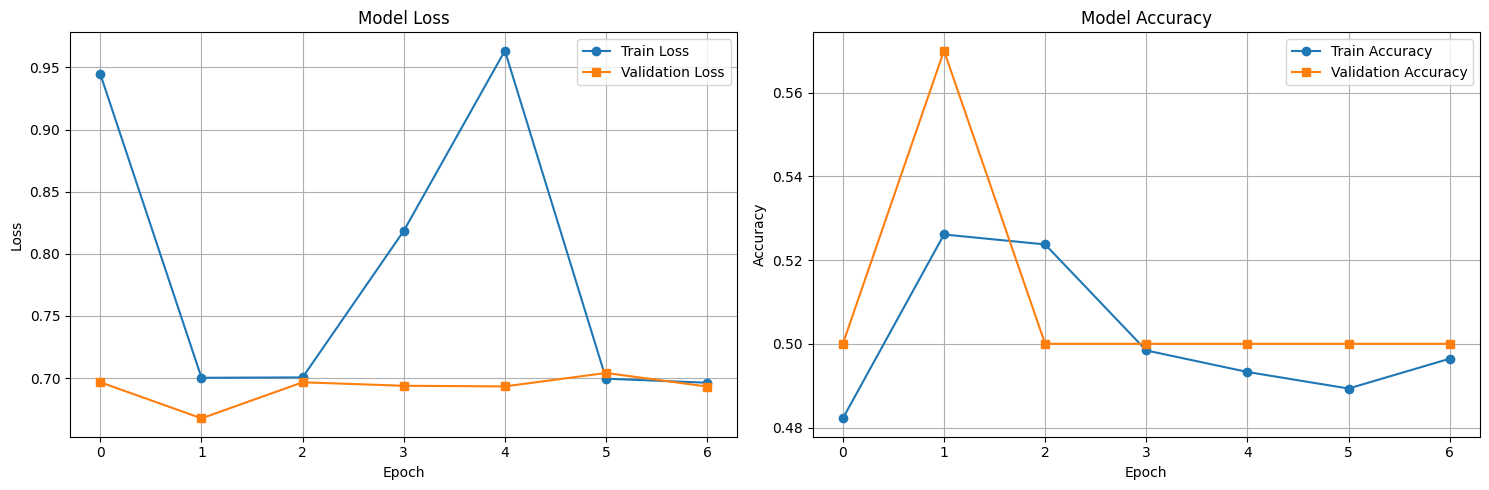

In [19]:
# Evaluate VGG-19
vgg19_test_acc, vgg19_preds, vgg19_labels = vgg19_trainer.evaluate_model()
vgg19_trainer.plot_training_history()

## 4. EfficientNet-B0 Training

In [20]:
# Create and train EfficientNet-B0
print("Creating EfficientNet-B0 model...")
effnet_b0_model = create_efficientnet_model('b0')
effnet_b0_trainer = ModelTrainer(effnet_b0_model, train_loader, val_loader, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Creating EfficientNet-B0 model...


100%|██████████| 20.5M/20.5M [00:00<00:00, 189MB/s]


In [21]:
# Train EfficientNet-B0
print("Training EfficientNet-B0...")
trained_effnet_b0 = effnet_b0_trainer.train_model(num_epochs=25, model_name='effnet-b0')

Training EfficientNet-B0...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.38it/s, Loss=0.4753, Acc=0.7816]


Train Loss: 0.4753 Acc: 0.7816


Val : 100%|██████████| 4/4 [00:00<00:00,  8.37it/s, Loss=0.4135, Acc=0.8100]


Val Loss: 0.4135 Acc: 0.8100
✓ New best model saved with validation accuracy: 0.8100

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.64it/s, Loss=0.3217, Acc=0.8663]


Train Loss: 0.3217 Acc: 0.8663


Val : 100%|██████████| 4/4 [00:00<00:00,  8.62it/s, Loss=0.4344, Acc=0.8000]


Val Loss: 0.4344 Acc: 0.8000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.65it/s, Loss=0.2424, Acc=0.9031]


Train Loss: 0.2424 Acc: 0.9031


Val : 100%|██████████| 4/4 [00:00<00:00,  8.97it/s, Loss=0.4655, Acc=0.7900]


Val Loss: 0.4655 Acc: 0.7900

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.61it/s, Loss=0.1610, Acc=0.9351]


Train Loss: 0.1610 Acc: 0.9351


Val : 100%|██████████| 4/4 [00:00<00:00,  9.17it/s, Loss=0.7323, Acc=0.8300]


Val Loss: 0.7323 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.58it/s, Loss=0.1657, Acc=0.9407]


Train Loss: 0.1657 Acc: 0.9407


Val : 100%|██████████| 4/4 [00:00<00:00,  8.59it/s, Loss=0.4084, Acc=0.8200]


Val Loss: 0.4084 Acc: 0.8200

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.64it/s, Loss=0.0976, Acc=0.9620]


Train Loss: 0.0976 Acc: 0.9620


Val : 100%|██████████| 4/4 [00:00<00:00,  8.89it/s, Loss=0.4481, Acc=0.8400]


Val Loss: 0.4481 Acc: 0.8400
✓ New best model saved with validation accuracy: 0.8400

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.62it/s, Loss=0.0899, Acc=0.9668]


Train Loss: 0.0899 Acc: 0.9668


Val : 100%|██████████| 4/4 [00:00<00:00,  8.60it/s, Loss=0.9508, Acc=0.7900]


Val Loss: 0.9508 Acc: 0.7900

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.62it/s, Loss=0.0857, Acc=0.9691]


Train Loss: 0.0857 Acc: 0.9691


Val : 100%|██████████| 4/4 [00:00<00:00,  8.53it/s, Loss=0.7129, Acc=0.8300]


Val Loss: 0.7129 Acc: 0.8300

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.63it/s, Loss=0.0847, Acc=0.9707]


Train Loss: 0.0847 Acc: 0.9707


Val : 100%|██████████| 4/4 [00:00<00:00,  8.39it/s, Loss=0.5879, Acc=0.8400]


Val Loss: 0.5879 Acc: 0.8400

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.65it/s, Loss=0.0808, Acc=0.9719]


Train Loss: 0.0808 Acc: 0.9719


Val : 100%|██████████| 4/4 [00:00<00:00,  8.64it/s, Loss=0.8298, Acc=0.8100]


Val Loss: 0.8298 Acc: 0.8100

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.58it/s, Loss=0.0433, Acc=0.9838]


Train Loss: 0.0433 Acc: 0.9838


Val : 100%|██████████| 4/4 [00:00<00:00,  8.36it/s, Loss=0.8265, Acc=0.8400]

Val Loss: 0.8265 Acc: 0.8400
Early stopping triggered after 11 epochs
Training complete in 1m 46s
Best validation accuracy: 0.8400


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


Test Accuracy: 86.33%
Test Loss: 0.3778

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.82      0.93      0.87       150
Non_Autistic       0.92      0.80      0.85       150

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300


Confusion Matrix:
[[139  11]
 [ 30 120]]


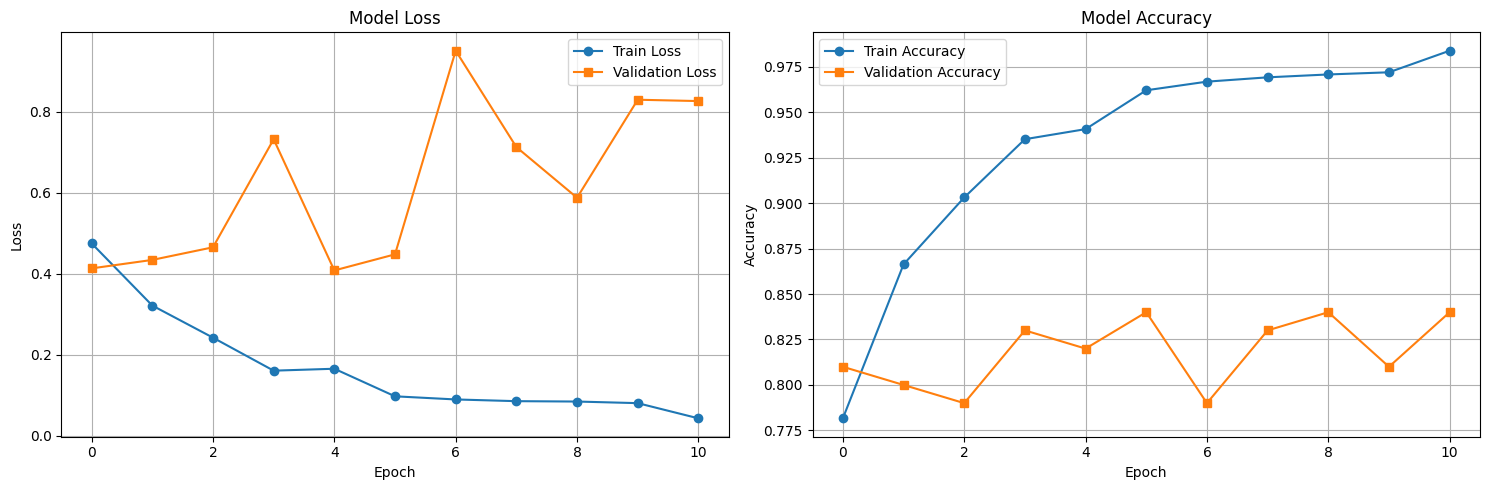

In [22]:
# Evaluate EfficientNet-B0
effnet_b0_test_acc, effnet_b0_preds, effnet_b0_labels = effnet_b0_trainer.evaluate_model()
effnet_b0_trainer.plot_training_history()

## 5. EfficientNet-B1 Training

In [23]:
# Create and train EfficientNet-B1
print("Creating EfficientNet-B1 model...")
effnet_b1_model = create_efficientnet_model('b1')
effnet_b1_trainer = ModelTrainer(effnet_b1_model, train_loader, val_loader, test_loader, device)

Creating EfficientNet-B1 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 35.0MB/s]


In [24]:
# Train EfficientNet-B1
print("Training EfficientNet-B1...")
trained_effnet_b1 = effnet_b1_trainer.train_model(num_epochs=25, model_name='effnet-b1')

Training EfficientNet-B1...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Loss=0.4603, Acc=0.7832]


Train Loss: 0.4603 Acc: 0.7832


Val : 100%|██████████| 4/4 [00:00<00:00,  7.27it/s, Loss=0.6223, Acc=0.7300]


Val Loss: 0.6223 Acc: 0.7300
✓ New best model saved with validation accuracy: 0.7300

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.15it/s, Loss=0.2911, Acc=0.8794]


Train Loss: 0.2911 Acc: 0.8794


Val : 100%|██████████| 4/4 [00:00<00:00,  7.48it/s, Loss=0.5348, Acc=0.7600]


Val Loss: 0.5348 Acc: 0.7600
✓ New best model saved with validation accuracy: 0.7600

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Loss=0.1942, Acc=0.9229]


Train Loss: 0.1942 Acc: 0.9229


Val : 100%|██████████| 4/4 [00:00<00:00,  7.91it/s, Loss=0.5073, Acc=0.8300]


Val Loss: 0.5073 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.16it/s, Loss=0.1214, Acc=0.9529]


Train Loss: 0.1214 Acc: 0.9529


Val : 100%|██████████| 4/4 [00:00<00:00,  7.66it/s, Loss=0.5127, Acc=0.8100]


Val Loss: 0.5127 Acc: 0.8100

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.15it/s, Loss=0.0946, Acc=0.9648]


Train Loss: 0.0946 Acc: 0.9648


Val : 100%|██████████| 4/4 [00:00<00:00,  7.54it/s, Loss=0.9122, Acc=0.7400]


Val Loss: 0.9122 Acc: 0.7400

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.14it/s, Loss=0.0938, Acc=0.9660]


Train Loss: 0.0938 Acc: 0.9660


Val : 100%|██████████| 4/4 [00:00<00:00,  7.33it/s, Loss=0.7487, Acc=0.7200]


Val Loss: 0.7487 Acc: 0.7200

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.16it/s, Loss=0.0963, Acc=0.9660]


Train Loss: 0.0963 Acc: 0.9660


Val : 100%|██████████| 4/4 [00:00<00:00,  7.67it/s, Loss=0.8860, Acc=0.7600]


Val Loss: 0.8860 Acc: 0.7600

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.14it/s, Loss=0.0583, Acc=0.9794]


Train Loss: 0.0583 Acc: 0.9794


Val : 100%|██████████| 4/4 [00:00<00:00,  7.48it/s, Loss=0.4149, Acc=0.8500]


Val Loss: 0.4149 Acc: 0.8500
✓ New best model saved with validation accuracy: 0.8500

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.14it/s, Loss=0.0499, Acc=0.9830]


Train Loss: 0.0499 Acc: 0.9830


Val : 100%|██████████| 4/4 [00:00<00:00,  7.54it/s, Loss=0.6082, Acc=0.8100]


Val Loss: 0.6082 Acc: 0.8100

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.15it/s, Loss=0.0718, Acc=0.9727]


Train Loss: 0.0718 Acc: 0.9727


Val : 100%|██████████| 4/4 [00:00<00:00,  7.53it/s, Loss=0.5938, Acc=0.8400]


Val Loss: 0.5938 Acc: 0.8400

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.16it/s, Loss=0.0518, Acc=0.9818]


Train Loss: 0.0518 Acc: 0.9818


Val : 100%|██████████| 4/4 [00:00<00:00,  7.40it/s, Loss=0.6405, Acc=0.7800]


Val Loss: 0.6405 Acc: 0.7800

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.09it/s, Loss=0.0507, Acc=0.9806]


Train Loss: 0.0507 Acc: 0.9806


Val : 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, Loss=0.7668, Acc=0.8200]


Val Loss: 0.7668 Acc: 0.8200

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Loss=0.0445, Acc=0.9818]


Train Loss: 0.0445 Acc: 0.9818


Val : 100%|██████████| 4/4 [00:00<00:00,  7.68it/s, Loss=0.8703, Acc=0.8100]

Val Loss: 0.8703 Acc: 0.8100
Early stopping triggered after 13 epochs
Training complete in 2m 55s
Best validation accuracy: 0.8500


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


Test Accuracy: 89.67%
Test Loss: 0.3785

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.85      0.96      0.90       150
Non_Autistic       0.95      0.83      0.89       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Confusion Matrix:
[[144   6]
 [ 25 125]]


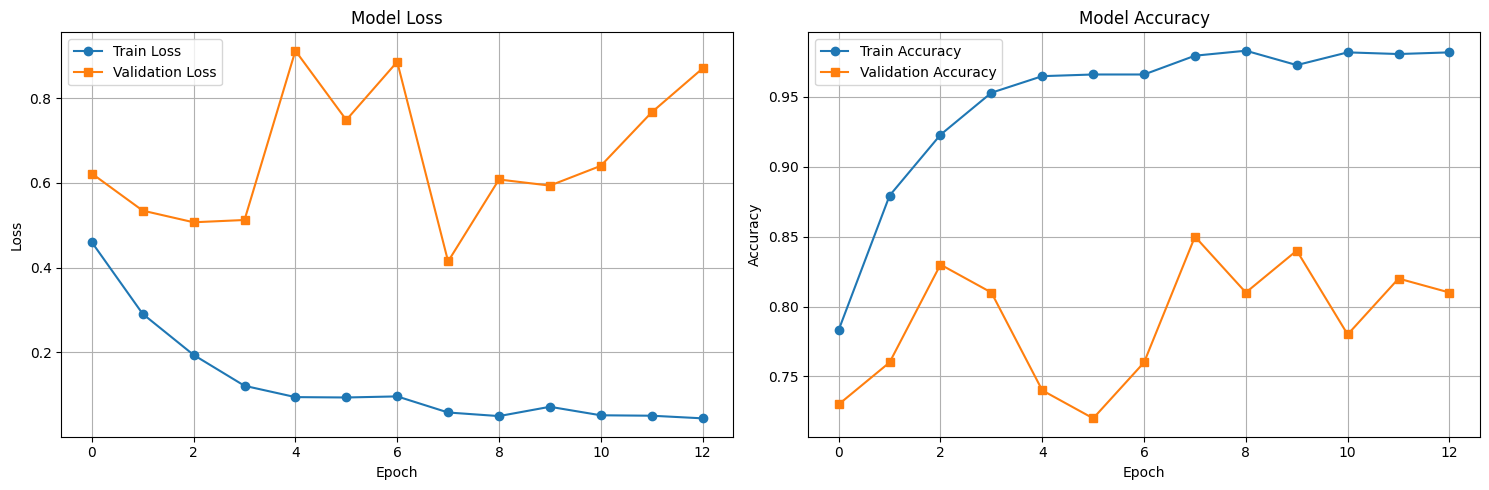

In [25]:
# Evaluate EfficientNet-B1
effnet_b1_test_acc, effnet_b1_preds, effnet_b1_labels = effnet_b1_trainer.evaluate_model()
effnet_b1_trainer.plot_training_history()

## 6. EfficientNet-B2 Training

In [26]:
# Create and train EfficientNet-B2
print("Creating EfficientNet-B2 model...")
effnet_b2_model = create_efficientnet_model('b2')
effnet_b2_trainer = ModelTrainer(effnet_b2_model, train_loader, val_loader, test_loader, device)

Creating EfficientNet-B2 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 188MB/s]


In [27]:
# Train EfficientNet-B2
print("Training EfficientNet-B2...")
trained_effnet_b2 = effnet_b2_trainer.train_model(num_epochs=25, model_name='effnet-b2')

Training EfficientNet-B2...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.78it/s, Loss=0.4718, Acc=0.7781]


Train Loss: 0.4718 Acc: 0.7781


Val : 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, Loss=0.4917, Acc=0.7400]


Val Loss: 0.4917 Acc: 0.7400
✓ New best model saved with validation accuracy: 0.7400

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.78it/s, Loss=0.3132, Acc=0.8695]


Train Loss: 0.3132 Acc: 0.8695


Val : 100%|██████████| 4/4 [00:00<00:00,  7.51it/s, Loss=0.4240, Acc=0.8200]


Val Loss: 0.4240 Acc: 0.8200
✓ New best model saved with validation accuracy: 0.8200

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.78it/s, Loss=0.2070, Acc=0.9221]


Train Loss: 0.2070 Acc: 0.9221


Val : 100%|██████████| 4/4 [00:00<00:00,  7.81it/s, Loss=0.5741, Acc=0.7600]


Val Loss: 0.5741 Acc: 0.7600

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.80it/s, Loss=0.1865, Acc=0.9308]


Train Loss: 0.1865 Acc: 0.9308


Val : 100%|██████████| 4/4 [00:00<00:00,  7.52it/s, Loss=0.5894, Acc=0.7400]


Val Loss: 0.5894 Acc: 0.7400

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.80it/s, Loss=0.1348, Acc=0.9466]


Train Loss: 0.1348 Acc: 0.9466


Val : 100%|██████████| 4/4 [00:00<00:00,  7.49it/s, Loss=0.8224, Acc=0.7300]


Val Loss: 0.8224 Acc: 0.7300

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.77it/s, Loss=0.1197, Acc=0.9494]


Train Loss: 0.1197 Acc: 0.9494


Val : 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, Loss=0.5140, Acc=0.8000]


Val Loss: 0.5140 Acc: 0.8000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.76it/s, Loss=0.1138, Acc=0.9585]


Train Loss: 0.1138 Acc: 0.9585


Val : 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, Loss=0.5675, Acc=0.7900]

Val Loss: 0.5675 Acc: 0.7900
Early stopping triggered after 7 epochs
Training complete in 1m 40s
Best validation accuracy: 0.8200


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Test Accuracy: 84.67%
Test Loss: 0.3690

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.78      0.97      0.86       150
Non_Autistic       0.96      0.72      0.82       150

    accuracy                           0.85       300
   macro avg       0.87      0.85      0.84       300
weighted avg       0.87      0.85      0.84       300


Confusion Matrix:
[[146   4]
 [ 42 108]]


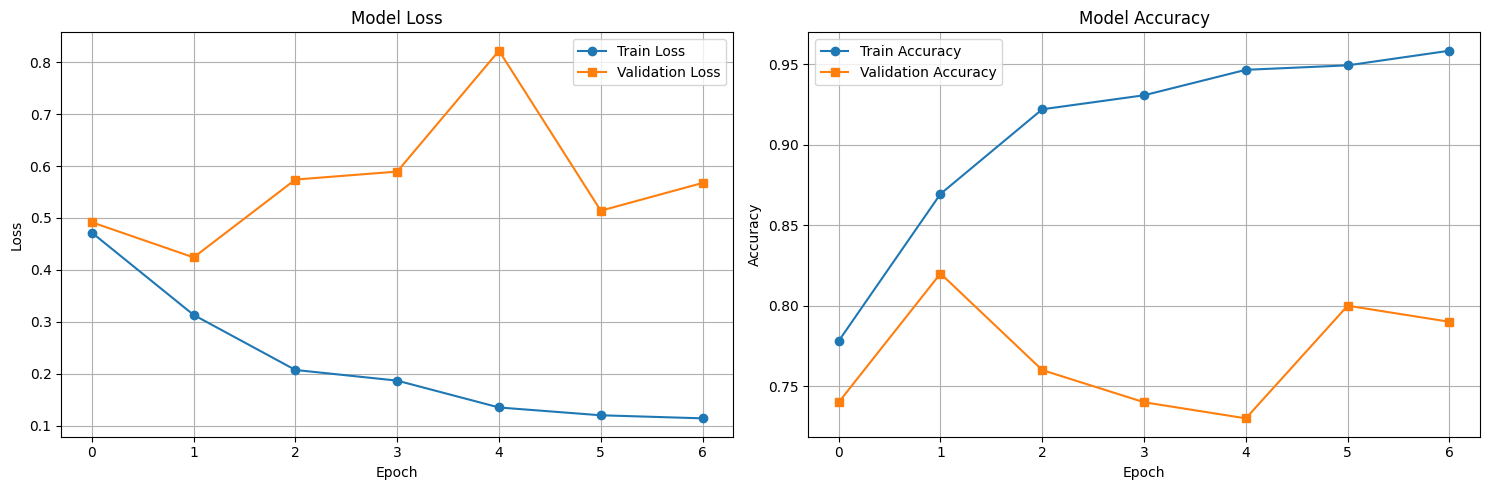

In [28]:
# Evaluate EfficientNet-B2
effnet_b2_test_acc, effnet_b2_preds, effnet_b2_labels = effnet_b2_trainer.evaluate_model()
effnet_b2_trainer.plot_training_history()

## Model Performance Summary

In [29]:
# Create a summary table of all model performances
results_summary = pd.DataFrame({
    'Model': ['ResNet-18', 'VGG-16', 'VGG-19', 'EfficientNet-B0', 'EfficientNet-B1', 'EfficientNet-B2'],
    'Test_Accuracy': [
        resnet_test_acc,
        vgg16_test_acc,
        vgg19_test_acc,
        effnet_b0_test_acc,
        effnet_b1_test_acc,
        effnet_b2_test_acc
    ]
})

# Sort by accuracy
results_summary = results_summary.sort_values('Test_Accuracy', ascending=False)

print("Model Performance Summary:")
print("=" * 40)
for idx, row in results_summary.iterrows():
    print(f"{row['Model']:<20}: {row['Test_Accuracy']:.2f}%")

print(f"\nBest performing model: {results_summary.iloc[0]['Model']} with {results_summary.iloc[0]['Test_Accuracy']:.2f}% accuracy")

Model Performance Summary:
EfficientNet-B1     : 89.67%
EfficientNet-B0     : 86.33%
EfficientNet-B2     : 84.67%
ResNet-18           : 81.00%
VGG-19              : 57.33%
VGG-16              : 53.00%

Best performing model: EfficientNet-B1 with 89.67% accuracy


## Model Comparison Visualization

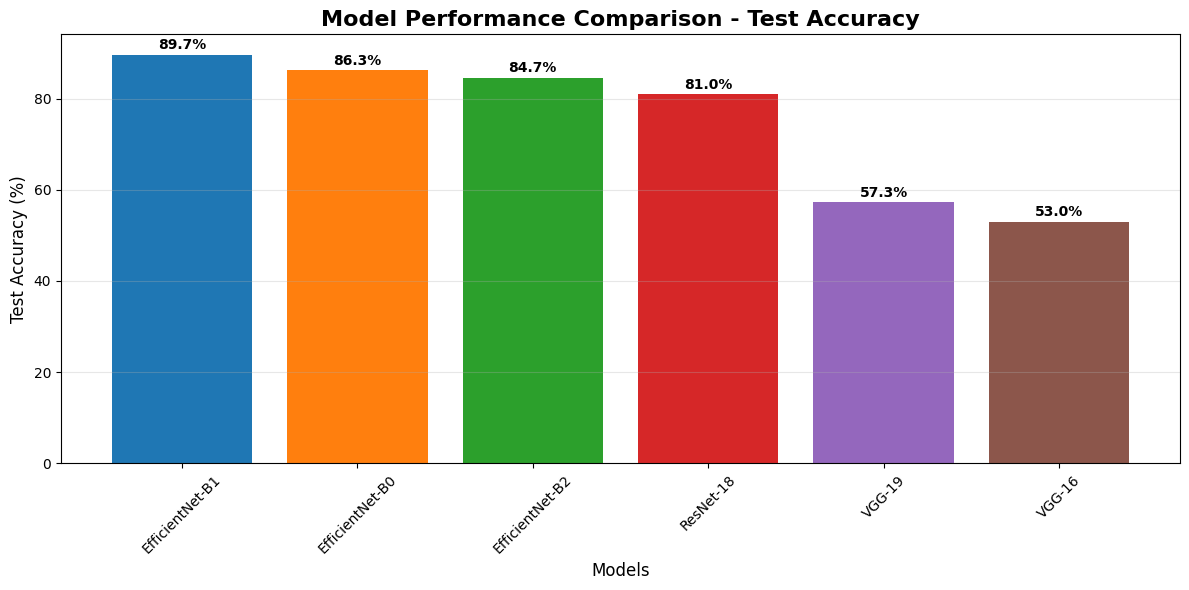

In [30]:
# Create a bar plot comparing model performances
plt.figure(figsize=(12, 6))
bars = plt.bar(results_summary['Model'], results_summary['Test_Accuracy'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

plt.title('Model Performance Comparison - Test Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, results_summary['Test_Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates the complete pipeline for:

1. **Data Preparation**: Converting the AutismDataset folder structure into organized DataFrames
2. **Data Loading**: Creating PyTorch datasets and dataloaders with appropriate transformations
3. **Model Training**: Training six different deep learning architectures:
   - ResNet-18
   - VGG-16
   - VGG-19
   - EfficientNet-B0
   - EfficientNet-B1
   - EfficientNet-B2
4. **Model Evaluation**: Comprehensive evaluation with accuracy, classification reports, and confusion matrices
5. **Performance Comparison**: Visual comparison of all models

The framework includes:
- Early stopping to prevent overfitting
- Best model saving
- Learning rate scheduling
- Comprehensive training history tracking
- Detailed evaluation metrics